# Laboratory 5: Convolutional Neural Networks

In this laboratory session we will train some CNNs to recognize color images in the [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1: Initial Setup and Data Exploration

We begin with some standard imports, as usual.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Standard Pytorch imports (note the aliases).
import torch
import torch.nn as nn
import torch.nn.functional as F

### Exercise 1.1: Dataset and Dataloader Preparation

The `torchvision` library provides a class (with the same interface as MNIST) for the CIFAR-10 dataset. As with MNIST, it will automatically download and prepare the dataset for use. Use the CIFAR10 class to load the training, validation (use 2000 images), and test splits.

**Note**: Don't forget to *transform* the images in the datasets to convert them to tensors and standardize them!

**Hint**: Feel free to copy-and-paste liberally from the notebook I published for the capsule lecture. **BUT**, make sure you know what you are doing, and be aware that *some* of the code will have to be adapted for use with the CIFAR10 dataset.

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

# Validation set size.
val_size = 2000

transform = transforms.Compose([
    transforms.ToTensor(),#meter aqui lo que falta fto
    transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
])
ds_orig = CIFAR10(root='./data', train=True, download=True)
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

#make train splits
(ds_train, ds_val)= torch.utils.data.random_split(ds_train, (len(ds_train)-val_size, val_size))
                                                    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
images = torch.stack([x for (x,y) in ds_train], dim=0)

### Exercise 1.2: Dataloaders
Set up dataloaders for **all** of the datasets -- even though the validation set is small! Test out the datasets defined above and the dataloaders to make sure you understand the dataset format. Visualize some of the images to get a feel for the type of images and classes in CIFAR-10.

In [3]:
# Setup dataloaders for all three datasets. Use the largest batch size possible.
batch_size = 256

from torch.utils.data import DataLoader
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=8)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)
dl_test = DataLoader(ds_train, batch_size=batch_size, shuffle=False)


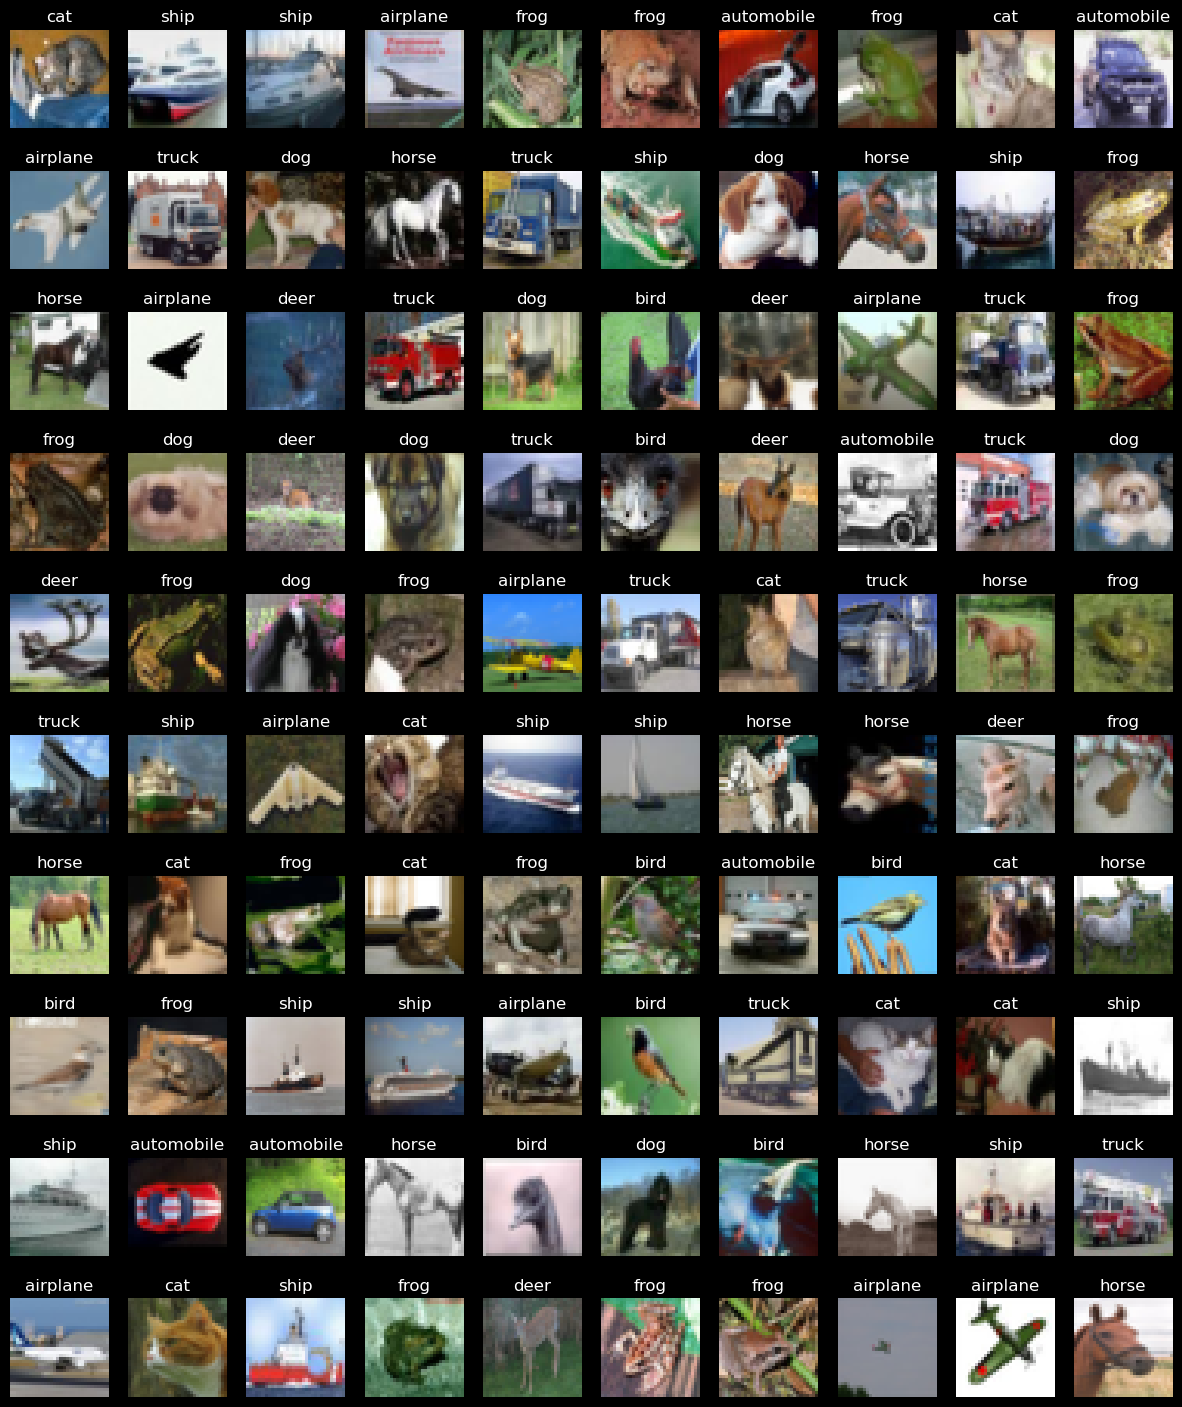

In [5]:
plt.figure(figsize=(15,18))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(ds_test.data[i])
    plt.axis('off')
    plt.title (ds_test.classes[ds_test.targets[i]])
#plt.figure(figsize=(8,4))
#plt.subplot(1,2,1)
#plt.imshow(ds_orig[9][0])
#plt.subplot(1,2,2)
#plt.imshow(ds_train[9][0].permute(1,2,0))
#plt.imshow(ds_train[0][0].permute(1,2,0))
#a la izquierda la imagen original a la derecha tendria que salir algo parecido
#imshow va a quejarse por como se colocan pipes y channels y tal

## Part 2: Establishing a stable baseline

In this part of the laboratory we will establish a simple baseline as a starting point.

### Exercise 2.1: An MLP Baseline

Define a simple Multilayer Perceptron to classify the CIFAR-10 images. Define it as a class inheriting from torch.nn.Module. Don't make it too complex or too deep. We're just looking for a starting point. A *baseline*.

In [4]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

# Simple function to count the parameters in a model.
def count_parameters(model):
    return np.sum([p.numel() for p in model.parameters()])

In [5]:

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3= nn.Linear(64,32)
        self.output= nn.Linear(32,10)
        self.relu= nn.ReLU()
        
    
    def forward(self, x):
        x = self.relu(self.fc1(x.view(len(x),-1)))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.output(x)
        
 #copio y pego del de ejemplo antes de esto   
#lo estoy haciendo con 3 capas pero mirar si lo pide con 2

### Exercise 2.2: Train and Evaluate your MLP Baseline

Train the model for a few (say, 20) epochs. Again, feel free to use my training code from the Capsule Lecture (or roll your own, mine is very basic). Make sure you plot training curves and report accuracy on the test set.

Training epoch 19: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:36<00:00,  5.12it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.633     0.672     0.652      4811
           1      0.720     0.713     0.716      4798
           2      0.514     0.415     0.459      4820
           3      0.468     0.411     0.437      4786
           4      0.516     0.509     0.512      4815
           5      0.528     0.469     0.497      4785
           6      0.577     0.681     0.625      4800
           7      0.668     0.712     0.690      4802
           8      0.707     0.728     0.717      4793
           9      0.631     0.700     0.664      4790

    accuracy                          0.601     48000
   macro avg      0.596     0.601     0.597     48000
weighted avg      0.596     0.601     0.597     48000



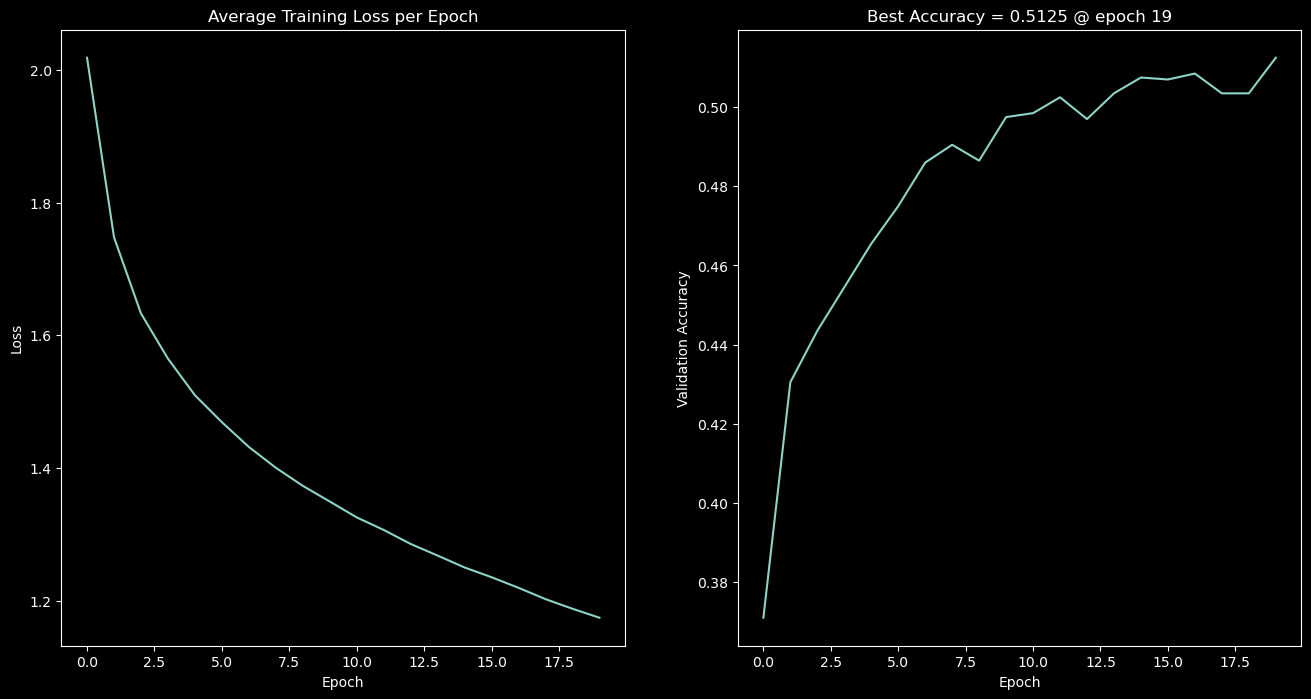

In [9]:
# Training hyperparameters.
device = 'cpu'
lr = 0.0001
epochs = 20

# Instantiate our model and optimizer.
model_mlp = MLP().to(device)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=lr)

# Our outer training loop, collect loss on train and accuracy on validation.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_mlp, dl_test, device=device)[1]}')

**Analysis:** Now we know the evaluation on our baseline, with an accuraccy of 0.601, and we can see the training curves. We can see that with each epoch that is trained the average trainig loss decreases as we want it to decrease, and the validation accuracy goes up.

## Part 3: A CNN for CIFAR-10 Classification

OK, we have a (simple) MLP baseline for comparison. Let's implement a simple CNN to classify CIFAR-10 images and see if we can beat the MLP.

### Exercise 3.1: Defining the CNN

Define a simple CNN model with a few convolutional and maxppooling layers -- not too many, since CIFAR-10 images are only 32x32 pixels! Use two fully-connected layers after the last convolution and before the logit outputs. Test out the model by passing a *single* image through it to make sure it's working.

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*4*4,512)
        self.fc2 = nn.Linear(512,64)
        self.output = nn.Linear(64,10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x= self.pool(self.relu(self.conv2(x)))
        x= self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64*4*4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.output(x)  

### Exercise 3.2: Training and Evaluating your CNN

Train the CNN using similar hyperparameters to what you used for the MLP above (epochs, learning rate). Evaluate the model in the same way as before.

Training epoch 19: 100%|█████████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.674     0.672     0.673      4789
           1      0.761     0.680     0.718      4799
           2      0.539     0.503     0.520      4800
           3      0.479     0.420     0.448      4794
           4      0.604     0.462     0.524      4820
           5      0.561     0.508     0.533      4795
           6      0.558     0.784     0.652      4822
           7      0.624     0.729     0.672      4800
           8      0.834     0.653     0.732      4801
           9      0.600     0.763     0.672      4780

    accuracy                          0.617     48000
   macro avg      0.623     0.617     0.614     48000
weighted avg      0.623     0.617     0.614     48000



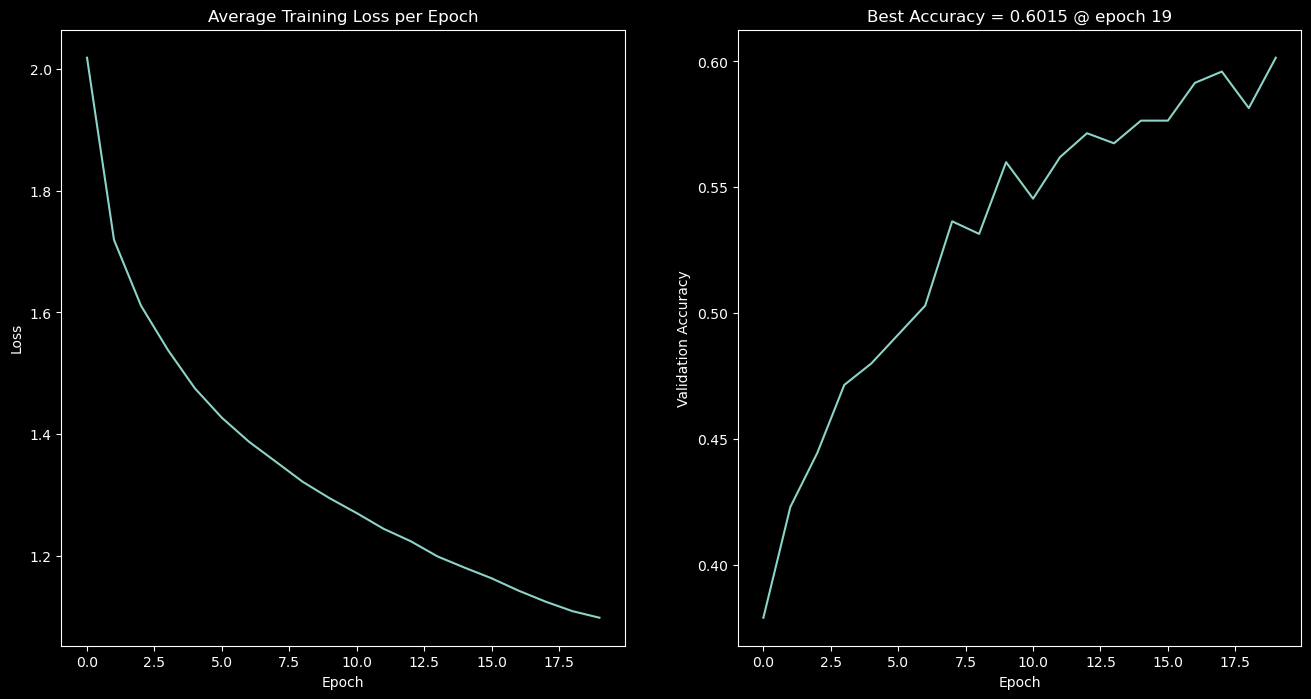

In [40]:
# Training hyperparameters.
device = 'cpu'
lr = 0.0001
epochs = 20

# Instantiate our model and optimizer.
model_cnn = CNN().to(device)
optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=lr)

# Our outer training loop, collect loss on train and accuracy on validation.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_cnn, dl_train, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(model_cnn, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_cnn, dl_test, device=device)[1]}')

**Analysis:** Now with our CNN we can see that the duration of the training of each epoch, around 1:10 instead of 0:35 that was with our baseline. The accuracy of the CNN test is 0.617, a little bit better than the baseline. Maybe if we trained with more epochs, we will see a more notorious difference, but in this case is not a lot. In the graph on the right we can see the best accuracy (in epoch 19) that in the baseline is of 0.51 and here is 0.60. This is an experiment using the same number of epoch and the same learning rate and the CNN, even though, is similar, can get better results in the long run.

## Going Forward

In practice we usually don't train deep models from *scratch*. Especially if we don't have a lot of annotated data we almost always use a **pre-trained** model either as a **feature extractor** or to **fine-tune** on our problem. The Torchvision library supports access to a [huge variety or pre-trained models](https://pytorch.org/vision/stable/models/resnet.html) that you can use for *exactly* this purpose. Keep this in mind if you have an image recognition problem -- you can use a pre-trained model as a **feature extractor** and then train a *simple* MLP to solve your classification problem. This works *very* well in practice.